In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# Use TrainAndValid.csv for train and validation set as it have `SalePrice`
TRAIN_SET = 'data/bluebook-for-bulldozers/TrainAndValid.csv'
# VALID_SET = to be extracted from TRAIN_SET
TEST_SET = 'data/bluebook-for-bulldozers/Test.csv'
PRED_SET = 'data/bluebook-for-bulldozers/prediction.csv'

### Helper Functions

In [3]:
def df_read_csv_time_series(filepath, label, sort=True):
    """
    Read all csv content to memory and parsing `label` as date.
    Add additional datetime tags based on `label`
    """
    df = pd.read_csv(filepath,
                    low_memory=False,
                    parse_dates=[label])
    
    df['dtYear'] = df[label].dt.year
    df['dtMonth'] = df[label].dt.month
    df['dtDay'] = df[label].dt.day
    df['dtDayOfYear'] = df[label].dt.dayofyear
    df['dtDayOfWeek'] = df[label].dt.dayofweek

    if sort:
        df = df.sort_values(by=label, ascending=True)
    return df

In [4]:
def df_string_as_enum(df):
    """
    Convert all features type `string` to `category` enum.
    Add tag if feature is NaN
    """
    for label, content in df.items():
        if pd.api.types.is_string_dtype(content):
            content = content.astype('category').cat.as_ordered()
            df[label] = pd.Categorical(content).codes + 1
            if content.isna().sum():
                df['nan' + label] = content.isna()

In [5]:
def df_numeric_nan_as_median(df):
    """
    Update all features type `numeric` with NaN with the feature median
    Add tag if feature is NaN
    """
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if content.isna().sum():
                df[label] = content.fillna(content.median())
                df['nan' + label] = content.isna()            

In [6]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_log_error

def rmsle(y_true, y_pred):
    """
    Calculate RSMLE
    """
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

def model_evaluate_regression(model, X_train, X_valid, y_train, y_valid):
    """
    Evaluate model performance
    """
    train_pred = model.predict(X_train)
    valid_pred = model.predict(X_valid)
    performance = {'Train R^2': r2_score(y_train, train_pred),
                    'Valid R^2': r2_score(y_valid, valid_pred),
                    'Train MAE': mean_absolute_error(y_train, train_pred),
                    'Valid MAE': mean_absolute_error(y_valid, valid_pred),
                    'Train RMSLE': rmsle(y_train, train_pred),
                    'Valid RMSLE': rmsle(y_valid, valid_pred)}
    return performance

In [7]:
def model_plot_feature_importances(model, X_train, top=25):
    """
    Plot feature importances figure
    """
    df = (pd.DataFrame({
            'features': X_train.columns,
            'importance': model.feature_importances_})
        .sort_values('importance', ascending=False)
        .reset_index(drop=True))
        
    fig, ax = plt.subplots()
    ax.barh(df['features'][:top], df['importance'][:top])
    ax.set_ylabel('Features')
    ax.set_xlabel('Attribute Importance')
    ax.invert_yaxis()    

### Training Set

In [8]:
# Initial import training set
df = pd.read_csv(TRAIN_SET,
                nrows=100)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 53 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   SalesID                   100 non-null    int64 
 1   SalePrice                 100 non-null    int64 
 2   MachineID                 100 non-null    int64 
 3   ModelID                   100 non-null    int64 
 4   datasource                100 non-null    int64 
 5   auctioneerID              100 non-null    int64 
 6   YearMade                  100 non-null    int64 
 7   MachineHoursCurrentMeter  100 non-null    int64 
 8   UsageBand                 88 non-null     object
 9   saledate                  100 non-null    object
 10  fiModelDesc               100 non-null    object
 11  fiBaseModel               100 non-null    object
 12  fiSecondaryDesc           63 non-null     object
 13  fiModelSeries             15 non-null     object
 14  fiModelDescriptor         2

In [10]:
df['saledate'][:10]

0    11/16/2006 0:00
1     3/26/2004 0:00
2     2/26/2004 0:00
3     5/19/2011 0:00
4     7/23/2009 0:00
5    12/18/2008 0:00
6     8/26/2004 0:00
7    11/17/2005 0:00
8     8/27/2009 0:00
9      8/9/2007 0:00
Name: saledate, dtype: object

In [11]:
# Import training set parsing 'saledate'
df = df_read_csv_time_series(TRAIN_SET, 'saledate')

In [12]:
df['saledate'][:10]

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
Name: saledate, dtype: datetime64[ns]

In [13]:
df.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [14]:
(df.isna().sum() / len(df))[:100]

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
saledate                    0.000000
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
T

In [15]:
df_string_as_enum(df)

In [16]:
# Split based on Kaggle data description
# Use copy to prevent data leakage when finding median of numeric columns
df_train = df[df['dtYear'] < 2012].copy()
df_valid = df[df['dtYear'] == 2012].copy()

len(df_train), len(df_valid)

(401125, 11573)

In [17]:
df_numeric_nan_as_median(df_train)

In [18]:
df_numeric_nan_as_median(df_valid)

In [19]:
X_train, y_train= df_train.drop(['saledate', 'SalePrice'], axis=1), df_train['SalePrice']
X_valid, y_valid= df_valid.drop(['saledate', 'SalePrice'], axis=1), df_valid['SalePrice']
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((401125, 96), (11573, 95), (401125,), (11573,))

In [20]:
set(X_train) - set(X_valid)

{'nanauctioneerID'}

In [21]:
X_valid['nanauctioneerID'] = False
set(X_train) - set(X_valid)

set()

### Baseline Model

In [22]:
%%time
model = RandomForestRegressor(n_jobs=-1,
                             random_state=42,
                             max_samples=10000)
model.fit(X_train, y_train)

Wall time: 9.71 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [23]:
# Baseline
model_evaluate_regression(model, X_train, X_valid, y_train, y_valid)

{'Train R^2': 0.8606518328148955,
 'Valid R^2': 0.8327189060691302,
 'Train MAE': 5560.260031885321,
 'Valid MAE': 7183.140483020825,
 'Train RMSLE': 0.25767015974343244,
 'Valid RMSLE': 0.2940561524165024}

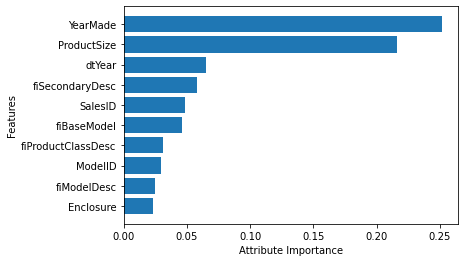

In [24]:
model_plot_feature_importances(model, X_train, 10)

### Hyperparameters Tuning

In [25]:
%%time
# Bruteforce hyperparameters tuning
param = {'n_estimators': np.arange(10, 100, 10),
         'max_depth': [None, 3, 5, 10],
         'min_samples_split': np.arange(2, 20, 2),
         'min_samples_leaf': np.arange(1, 20, 2),
         'max_features': [0.5, 1, 'sqrt', 'auto'],
         'max_samples': [10000]}

model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                 random_state=42),
                                                 param_distributions=param,
                                                 cv=5,
                                                 n_iter=5,
                                                 verbose=True)
model.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Wall time: 1min 30s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=5,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [26]:
model.best_params_

{'n_estimators': 60,
 'min_samples_split': 18,
 'min_samples_leaf': 5,
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': None}

In [27]:
# Post hyperparameter tuning
model_evaluate_regression(model, X_train, X_valid, y_train, y_valid)

{'Train R^2': 0.828747151329131,
 'Valid R^2': 0.8142166681659919,
 'Train MAE': 6201.426052928105,
 'Valid MAE': 7561.326200244256,
 'Train RMSLE': 0.28058840843612604,
 'Valid RMSLE': 0.30651397309916334}

### Test Set

In [28]:
# Import test set
df_test = df_read_csv_time_series(TEST_SET, 'saledate')

In [29]:
df_string_as_enum(df_test)

In [30]:
df_numeric_nan_as_median(df_test)

In [31]:
X_test= df_test.drop(['saledate'], axis=1)
X_test.shape

(12457, 95)

In [32]:
set(X_train) - set(X_test)

{'nanauctioneerID'}

In [33]:
X_test['nanauctioneerID'] = False
set(X_train) - set(X_test)

set()

In [34]:
y_pred = model.predict(X_test)

In [35]:
y_pred

array([10330.19607421, 17972.80888836, 21692.23473864, ...,
       46580.51529013, 49587.27635656, 34910.78440276])

In [36]:
# Generate prediction dataframe
df_pred = pd.DataFrame({
    'SalesID': df_test['SalesID'],
    'Sales_Price': y_pred})
df_pred.head()

,SalesID,Sales_Price
1408,4317459,10330.196074
1023,4249784,17972.808888
1728,4392603,21692.234739
1167,4274831,34619.380984
1594,4362801,15501.736617


In [37]:
# Export prediction dataframe
df_pred.to_csv(PRED_SET, index=False)